In [1]:
import numpy as np
import matplotlib.pyplot as plt
import PIL
import qiskit

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.ibmq import least_busy

from PIL import Image

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# Loading our image in the Quantum State
test_image = Image.open('test_4x4_image.tif')
np_test_image = np.array(test_image)

# We need to do this so that we take only a single channel of the color data in the .tif image
test_image_final = []
for row in np_test_image:
    for pixel in row:
        test_image_final.append( pixel[0] / 256)

np_test_image = np.array(test_image_final)

np_test_image = np_test_image.reshape((4,4))
print(np_test_image)


[[0.8125     0.84765625 0.86328125 0.8515625 ]
 [0.88671875 0.89453125 0.22265625 0.8984375 ]
 [0.2890625  0.890625   0.49609375 0.8984375 ]
 [0.43359375 0.89453125 0.38671875 0.4375    ]]


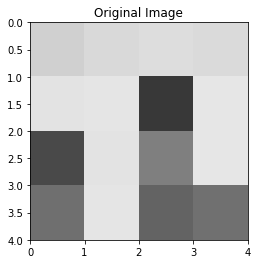

In [3]:
# Function to plot our image
def plot_image4x4(img, title: str):
    plt.title(title)
    plt.imshow(img, extent=[0, 4, 4, 0], vmin=0, vmax=1, cmap='gray')
    plt.show()
    
plot_image4x4(np_test_image, "Original Image")   

[[0.2778443  0.2898664  0.29520956 0.29120219]
 [0.3032243  0.30589588 0.07614002 0.30723167]
 [0.09884845 0.30456009 0.16964532 0.30723167]
 [0.14827268 0.30589588 0.1322432  0.14960847]]


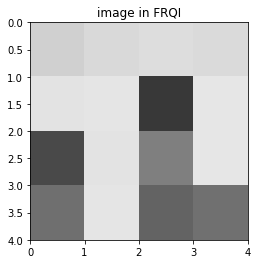

In [4]:
# We need to normalize our input image before passing it as the input quantum state.
def normalize(array):
    rms = np.sqrt(np.sum(np.sum(array**2)))
    ret_array = []
    for i in array:
        ret_array.append( (i * (1/rms)) )
    
    npret_array = np.array(ret_array)
    return npret_array

# The normalized image is too dark, so we brighten it with this method
def plot_image4x4_brightened(img, title: str):
    plt.title(title)
    plt.imshow(img, extent=[0, 4, 4, 0], vmin=0, vmax=0.34, cmap='gray')
    plt.show()
    
def plot_image4x4_denormalized(image, true_image, true_image_normalized, title: str):
    normalization_factor = 0.0
    for x in range(4):
        for y in range(4):
            normalization_factor += (true_image_normalized[y][x] / true_image[y][x])
    
    #The average normalization factor, to account for floating point errors.
    normalization_factor /= (4**2)
    
    image_plot = image / normalization_factor
    
    plt.title(title)
    plt.imshow(image_plot, extent=[0, 4, 4, 0], vmin=0, vmax=1, cmap='gray')
    plt.show()
    

np_test_image_normalized = normalize(np_test_image)
print(np_test_image_normalized)

plot_image4x4_denormalized(np_test_image, np_test_image_normalized, np_test_image_normalized, 'image in FRQI')

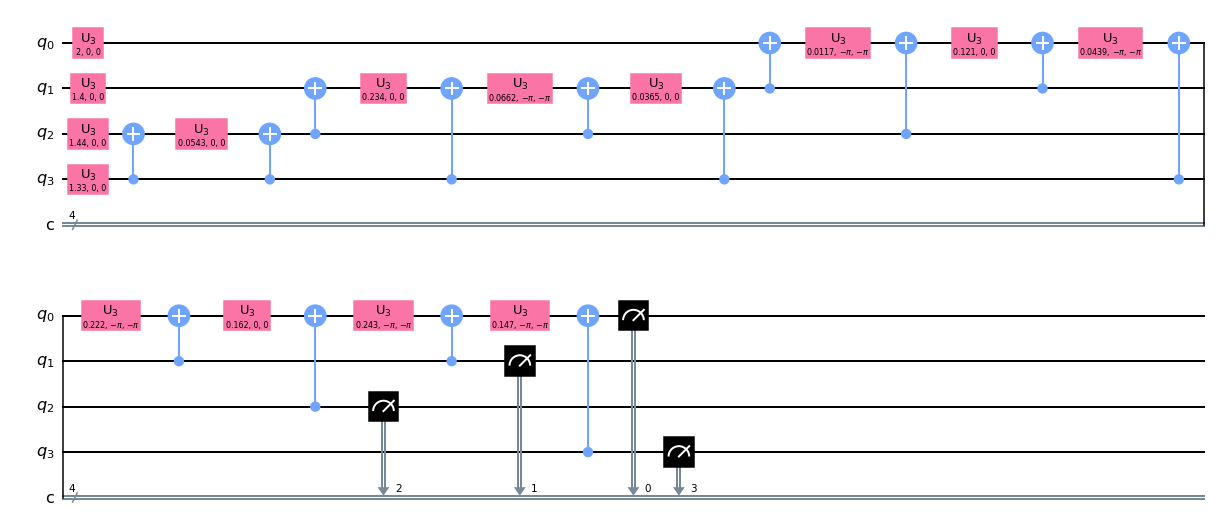

In [5]:
# Our Quantum Circuit that initializes the FRQI image
qc_image = QuantumCircuit(4,4)

qc_image.initialize(np_test_image_normalized.reshape(16))

qc_image.measure(range(4), range(4))

#qc_image = qc_image.decompose().decompose().decompose().decompose().decompose().decompose().decompose()
qc_image = qiskit.compiler.transpile(qc_image, basis_gates=["u1", "u2", "u3", "cx"])


qc_image.draw()

In [6]:
import sys
!{sys.executable} -m pip install mitiq

  Using cached mitiq-0.18.0-py3-none-any.whl (142 kB)
  Using cached scipy-1.7.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (39.3 MB)
  Using cached numpy-1.20.3-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.4 MB)
  Using cached cirq-1.0.0-py3-none-any.whl (7.8 kB)
  Using cached cirq_ionq-1.0.0-py3-none-any.whl (57 kB)
  Using cached cirq_core-1.0.0-py3-none-any.whl (1.8 MB)
  Using cached cirq_web-1.0.0-py3-none-any.whl (594 kB)
  Using cached cirq_aqt-1.0.0-py3-none-any.whl (27 kB)
  Using cached cirq_google-1.0.0-py3-none-any.whl (576 kB)
  Using cached cirq_pasqal-1.0.0-py3-none-any.whl (31 kB)
  Using cached cirq_rigetti-1.0.0-py3-none-any.whl (66 kB)
  Using cached duet-0.2.7-py3-none-any.whl (28 kB)
  Using cached protobuf-3.20.3-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.0 MB)
  Using cached google_api_core-1.33.1-py3-none-any.whl (115 kB)
  Using cached proto_plus-1.22.1-py3-none-any.whl (47 kB)
  Using cached pyquil-3.3.1-py3-none-an

In [7]:
# Importing mitiq and curve fitting
import mitiq
from qiskit.test.mock import FakeLima
from qiskit.providers.aer.noise import NoiseModel
from mitiq import zne

from scipy.optimize import curve_fit

/tmp/ipykernel_59/2602818812.py:3: DeprecationWarning: The module 'qiskit.test.mock' is deprecated since Qiskit Terra 0.21.0, and will be removed 3 months or more later. Instead, you should import the desired object directly 'qiskit.providers.fake_provider'.
  from qiskit.test.mock import FakeLima


In [14]:
# The simple ZNE function that comes with mitiq only supports a single float output 
# Since we want to recreate an entire image, I had to recreate the method in a lower level

#Factors to adjust noise
scale_factors = [1., 1.5, 2., 2.5, 3.]
# Generating a bunch of noiser circuits
folded_circuits = [
        mitiq.zne.scaling.folding.fold_all(
        qc_image, scale) for scale in scale_factors
]

shots = 4000
noisy_backend = FakeLima()

job = qiskit.execute(
   experiments=folded_circuits,
   backend=noisy_backend,
   optimization_level=0,  # Important!
   shots=shots
)
# We're adding our own error, so we don't want qiskit to optimize anything!
# That's why optimization_level = 0

In [15]:
# Lambda to convert between integer and it's binary string representation
get_bin = lambda x, n: format(x, 'b').zfill(n)

# Linear Fit
def linear_function(x, a, b):
    return a + (b * x)

zne_output = []

all_counts = [job.result().get_counts(i) for i in range(len(folded_circuits))]
expectation_values = []
for i in range(16):
    expectation_values.append([np.sqrt((counts.get(get_bin(i, 4)) / shots)) for counts in all_counts])
    
for i in range(16):
    # Fitting the curve to the data points to extrapolate ZNE output
    param, param_cov = curve_fit(linear_function, scale_factors, expectation_values[i])
    zne_output.append(linear_function(0, param[0], param[1]))
    
print(zne_output)

[0.29380918504574705, 0.3130869092953963, 0.2989887533140758, 0.30246642767401444, 0.2873163886325948, 0.3030416938706118, 0.11989685271170636, 0.28267077493091186, 0.13554072822057028, 0.2924164189043964, 0.17538797253837946, 0.288250376958468, 0.15208714128386092, 0.27548191000178945, 0.1349514201884121, 0.18552295229088545]


[[0.31641539 0.31545807 0.25304559 0.31010796]
 [0.26851141 0.29759283 0.13571021 0.31584142]
 [0.15273291 0.34453227 0.18383535 0.2638138 ]
 [0.14208047 0.27278739 0.09483797 0.1488619 ]]


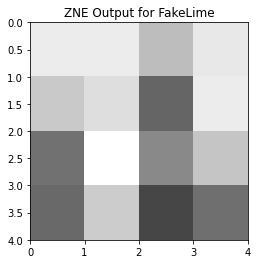

In [32]:
np_zne_output = np.array(zne_output)

np_zne_output = np_zne_output.reshape((4,4))
print(np_zne_output)

plot_image4x4_denormalized(np_zne_output, np_test_image, np_test_image_normalized, 'ZNE Output for FakeLime')

In [16]:
simulator_output = [0.2770379, 0.29197603, 0.29874738, 0.28504386,
 0.29453353, 0.30248967, 0.06123724, 0.31104662,
 0.09082951, 0.31424513, 0.16881943, 0.31064449,
 0.14491377, 0.30618622, 0.14230249, 0.14747881]
np_simulator_output = np.array(simulator_output).reshape((4,4))
print(np_simulator_output)

[[0.2770379  0.29197603 0.29874738 0.28504386]
 [0.29453353 0.30248967 0.06123724 0.31104662]
 [0.09082951 0.31424513 0.16881943 0.31064449]
 [0.14491377 0.30618622 0.14230249 0.14747881]]


[[0.30700163 0.34022052 0.29706902 0.31304952]
 [0.28106939 0.2792848  0.15165751 0.29916551]
 [0.17464249 0.30413813 0.17606817 0.23345235]
 [0.16507574 0.25932605 0.10723805 0.14053469]]


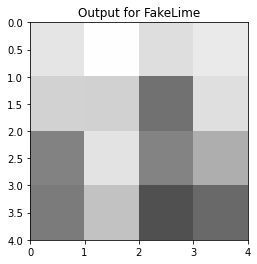

In [31]:
fake_lima_output = []
for i in range(16):
    fake_lima_output.append(expectation_values[i][0])

np_fake_lima_output = np.array(fake_lima_output).reshape((4,4))
print(np_fake_lima_output)

plot_image4x4_denormalized(np_fake_lima_output, np_test_image, np_test_image_normalized, 'Output for FakeLime')

In [22]:
# Calculating Error:
def un_normalize(true_image, true_image_normalized, image, n):
    normalization_factor = 0.0
    for x in range(n):
        for y in range(n):
            normalization_factor += (true_image_normalized[y][x] / true_image[y][x])
    
    #The average normalization factor, to account for floating point errors.
    normalization_factor /= (n**2)
    
    image = image / normalization_factor
    return image

def rmse_image_error(true_image, error_image, n):
    rms_error = 0.0
    for y in range(n):
        for x in range(n):
            rms_error += ((true_image[y][x] - error_image[y][x]) ** 2)
            
    rms_error = np.sqrt(rms_error)
    return (rms_error / (n**2))

rmse_simulator = rmse_image_error(np_test_image, un_normalize(np_test_image, np_test_image_normalized, np_simulator_output, 4), 4)
rmse_fake_lima = rmse_image_error(np_test_image, un_normalize(np_test_image, np_test_image_normalized, np_fake_lima_output, 4), 4) 
rmse_zne = rmse_image_error(np_test_image, un_normalize(np_test_image, np_test_image_normalized, np_zne_output, 4), 4) 

print("Simulator error: ", (rmse_simulator * 100), "% per pixel")
print("FakeLima error: ", (rmse_fake_lima * 100), "% per pixel")
print("FakeLima with ZNE error: ", (rmse_zne * 100), "% per pixel")

Simulator error:  0.4719698542319386 % per pixel
FakeLima error:  1.935837042552313 % per pixel
FakeLima with ZNE error:  1.6181118982833247 % per pixel


In [35]:
# Let's Run it on IBMQ_Kolkata!
scale_factors = [1., 1.5, 2., 2.5, 3.]
folded_circuits = [
        mitiq.zne.scaling.folding.fold_all(
        qc_image, scale) for scale in scale_factors
]

shots = 4000

# Running on actual Quantum Hardware:
IBMQ.load_account()
provider = IBMQ.get_provider(hub="ibm-q-iitmadras", group="mphasis-iitm", project="default")
backend_kolkata = provider.get_backend("ibmq_kolkata")
print("Chosen Backend: ", backend_kolkata)

job = qiskit.execute(
   experiments=folded_circuits,
   backend=backend_kolkata,
   optimization_level=0,  # We're adding our own error, so we don't want qiskit to optimize anything!
   shots=shots
)

ibmqfactory.load_account:WARNING:2022-10-01 10:58:10,406: Credentials are already in use. The existing account in the session will be replaced.


Chosen Backend:  ibmq_kolkata


In [23]:
#We're running on ibmq_kolkata Job_ID: 63381d49dee3d61327b9115e
IBMQ.load_account()
provider = IBMQ.get_provider(hub="ibm-q-iitmadras", group="mphasis-iitm", project="default")
backend_kolkata = provider.get_backend("ibmq_kolkata")
kolkata_job = backend_kolkata.retrieve_job('63381d49dee3d61327b9115e')

print(kolkata_job)

ibmqfactory.load_account:WARNING:2022-10-02 09:15:56,692: Credentials are already in use. The existing account in the session will be replaced.


In [24]:
get_bin = lambda x, n: format(x, 'b').zfill(n)

def linear_function(x, a, b):
    return a + (b * x)

zne_output = []

all_counts = [kolkata_job.result().get_counts(i) for i in range(len(folded_circuits))]
expectation_values = []
for i in range(16):
    expectation_values.append([np.sqrt((counts.get(get_bin(i, 4)) / shots)) for counts in all_counts])
    
for i in range(16):
    param, param_cov = curve_fit(linear_function, scale_factors, expectation_values[i])
    zne_output.append(linear_function(0, param[0], param[1]))
    
print(zne_output)

[0.3164153916131329, 0.3154580673452396, 0.25304559441111263, 0.3101079601541151, 0.2685114068166061, 0.2975928321243182, 0.13571021137733863, 0.31584142011213867, 0.15273291343079376, 0.34453227373763395, 0.1838353549912497, 0.2638137980958245, 0.14208047312347627, 0.27278739408648056, 0.09483797094983915, 0.1488619043073126]


[[0.31641539 0.31545807 0.25304559 0.31010796]
 [0.26851141 0.29759283 0.13571021 0.31584142]
 [0.15273291 0.34453227 0.18383535 0.2638138 ]
 [0.14208047 0.27278739 0.09483797 0.1488619 ]]


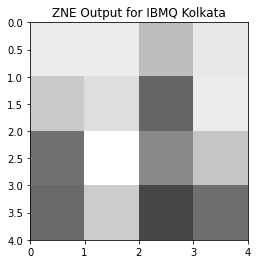

In [33]:
np_zne_output = np.array(zne_output)

np_zne_output = np_zne_output.reshape((4,4))
print(np_zne_output)

plot_image4x4_denormalized(np_zne_output, np_test_image, np_test_image_normalized, 'ZNE Output for IBMQ Kolkata')

[[0.30700163 0.34022052 0.29706902 0.31304952]
 [0.28106939 0.2792848  0.15165751 0.29916551]
 [0.17464249 0.30413813 0.17606817 0.23345235]
 [0.16507574 0.25932605 0.10723805 0.14053469]]


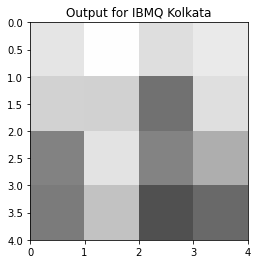

In [35]:
kolkata_output = []
for i in range(16):
    kolkata_output.append(expectation_values[i][0])

np_kolkata_output = np.array(kolkata_output).reshape((4,4))
print(np_kolkata_output)

plot_image4x4_denormalized(np_kolkata_output, np_test_image, np_test_image_normalized, 'Output for IBMQ Kolkata')

In [13]:
def un_normalize(true_image, true_image_normalized, image, n):
    normalization_factor = 0.0
    for x in range(n):
        for y in range(n):
            normalization_factor += (true_image_normalized[y][x] / true_image[y][x])
    
    #The average normalization factor, to account for floating point errors.
    normalization_factor /= (n**2)
    
    image = image / normalization_factor
    return image

def rmse_image_error(true_image, error_image, n):
    rms_error = 0.0
    for y in range(n):
        for x in range(n):
            rms_error += ((true_image[y][x] - error_image[y][x]) ** 2)
            
    rms_error = np.sqrt(rms_error)
    return (rms_error / (n**2))

rmse_simulator = rmse_image_error(np_test_image, un_normalize(np_test_image, np_test_image_normalized, np_simulator_output, 4), 4)
rmse_kolkata = rmse_image_error(np_test_image, un_normalize(np_test_image, np_test_image_normalized, np_kolkata_output, 4), 4) 
rmse_zne = rmse_image_error(np_test_image, un_normalize(np_test_image, np_test_image_normalized, np_zne_output, 4), 4) 

print("Simulator error: ", (rmse_simulator * 100), "% per pixel")
print("IBMQ Kolkata error: ", (rmse_fake_lima * 100), "% per pixel")
print("IMBQ Kolkata (with ZNE) error: ", (rmse_zne * 100), "% per pixel")

Traceback (most recent call last):
  Input In [13] in <cell line: 22>
    rmse_simulator = rmse_image_error(np_test_image, un_normalize(np_test_image, np_test_image_normalized, np_simulator_output, 4), 4)
NameError: name 'np_simulator_output' is not defined

Use %tb to get the full traceback.


In [37]:
print("True Image:")
print(np_test_image)
print("IBMQ Kolkata:")
print(un_normalize(np_test_image, np_test_image_normalized, np_kolkata_output, 4))
print("IBMQ Kolkata with ZNE:")
print(un_normalize(np_test_image, np_test_image_normalized, np_zne_output, 4))

True Image:
[[0.8125     0.84765625 0.86328125 0.8515625 ]
 [0.88671875 0.89453125 0.22265625 0.8984375 ]
 [0.2890625  0.890625   0.49609375 0.8984375 ]
 [0.43359375 0.89453125 0.38671875 0.4375    ]]
IBMQ Kolkata:
[[0.89776478 0.99490677 0.86871884 0.91545062]
 [0.82193113 0.81671247 0.44349201 0.87484961]
 [0.51070699 0.88939104 0.5148761  0.68268465]
 [0.48273094 0.7583471  0.31359621 0.41096557]]
IBMQ Kolkata with ZNE:
[[0.92529345 0.92249394 0.73998116 0.90684863]
 [0.78520784 0.87025064 0.39685733 0.92361498]
 [0.44663682 1.00751564 0.53758968 0.77147062]
 [0.41548589 0.7977121  0.27733465 0.43531683]]


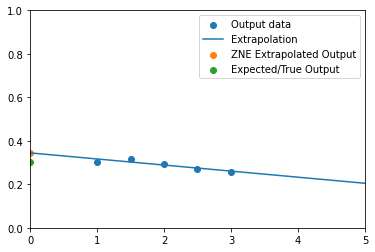

In [38]:
# We want to figure out why applying ZNE made things worse.
# Let's do it for pixel 0000:
plt.xlim([0, 5])
plt.ylim([0,1])

scale_factors_fitted = np.linspace(0, 5, 100)

plt.scatter(scale_factors, expectation_values[9], label="Output data")

param, param_cov = curve_fit(linear_function, scale_factors, expectation_values[9])

def lin_temp(x):
    return param[0] + (param[1] * x)

plt.plot(scale_factors_fitted, lin_temp(scale_factors_fitted), label="Extrapolation" )

plt.scatter(0, lin_temp(0), label="ZNE Extrapolated Output")
plt.scatter(0, np_test_image_normalized[2][1], label="Expected/True Output")

plt.legend()

plt.show()

In [82]:
def linear_function(x, a, b):
    return a + (b * x)

def plot_pixel_error_linear(scale_factors, expectation_values, test_image_normalized, x, y, n):
    plt.xlim([0, 5])
    plt.ylim([0,1])

    scale_factors_fitted = np.linspace(0, 5, 100)

    plt.scatter(scale_factors, expectation_values[x + (y * n)], label="Output data")
    param, param_cov = curve_fit(linear_function, scale_factors, expectation_values[x + (y * n)])
    
    scale_factors_fitted_output = []
    for x_output in scale_factors_fitted:
        scale_factors_fitted_output.append(linear_function(x_output, param[0], param[1]))
        
    np_scale_factors_fitted_output = np.array(scale_factors_fitted_output)
    plt.plot(scale_factors_fitted, np_scale_factors_fitted_output, label="Extrapolation" )

    plt.scatter(0, linear_function(0, param[0], param[1]), label="ZNE Extrapolated Output")
    plt.scatter(0, test_image_normalized[y][x], label="Expected/True Output")

    plt.title("Pixel Error Data for (" + str(x) + ", " + str(y) + ")")
    plt.legend()
    plt.show()

    
x = 1
y = 2
print(np_test_image_normalized[2][1])
print(type(np_test_image_normalized[2][1]))

0.30456009342437135
<class 'numpy.float64'>


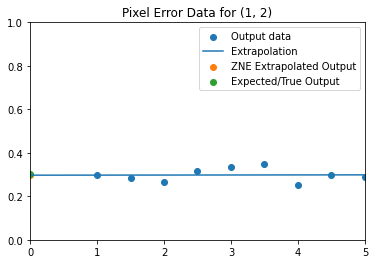

In [83]:
plot_pixel_error_linear(scale_factors, expectation_values, np_test_image_normalized, 1, 2, 4)

In [63]:
#We'll take another set of errors, and many more shots:
scale_factors = [1., 1.5, 2., 2.5, 3., 3.5, 4., 4.5, 5]
folded_circuits = [
        mitiq.zne.scaling.folding.fold_all(
        qc_image, scale) for scale in scale_factors
]

shots = 16000

# Running on actual Quantum Hardware:
IBMQ.load_account()
provider = IBMQ.get_provider(hub="ibm-q-iitmadras", group="mphasis-iitm", project="default")
backend_kolkata = provider.get_backend("ibmq_kolkata")
print("Chosen Backend: ", backend_kolkata)

job = qiskit.execute(
   experiments=folded_circuits,
   backend=backend_kolkata,
   optimization_level=0,  # We're adding our own error, so we don't want qiskit to optimize anything!
   shots=shots
)

ibmqfactory.load_account:WARNING:2022-10-02 09:47:46,429: Credentials are already in use. The existing account in the session will be replaced.


Chosen Backend:  ibmq_kolkata


In [64]:
# we ran this job on ibmq_kolkata job_id=63395e4d1ff56989f88b79a5
IBMQ.load_account()
provider = IBMQ.get_provider(hub="ibm-q-iitmadras", group="mphasis-iitm", project="default")
backend_kolkata = provider.get_backend("ibmq_kolkata")
kolkata_job = backend_kolkata.retrieve_job('63395e4d1ff56989f88b79a5')

print(kolkata_job)

ibmqfactory.load_account:WARNING:2022-10-02 09:49:18,743: Credentials are already in use. The existing account in the session will be replaced.


In [71]:
get_bin = lambda x, n: format(x, 'b').zfill(n)

def linear_function(x, a, b):
    return a + (b * x)

zne_output = []

all_counts = [kolkata_job.result().get_counts(i) for i in range(len(folded_circuits))]
expectation_values = []
for i in range(16):
    expectation_values.append([np.sqrt((counts.get(get_bin(i, 4)) / shots)) for counts in all_counts])
    
for i in range(16):
    param, param_cov = curve_fit(linear_function, scale_factors, expectation_values[i])
    zne_output.append(linear_function(0, param[0], param[1]))
    


np_zne_output = np.array(zne_output).reshape((4,4))

kolkata_output = []
for i in range(16):
    kolkata_output.append(expectation_values[i][0])
np_kolkata_output = np.array(kolkata_output).reshape((4,4))

print(np_zne_output)
print(np_kolkata_output)


[[0.30156948 0.31429695 0.26264326 0.30733257]
 [0.30586168 0.31756268 0.13082469 0.27682809]
 [0.14608489 0.29717832 0.18077594 0.26290938]
 [0.1706561  0.28443777 0.11575255 0.16281061]]
[[0.30465144 0.32768125 0.30516389 0.29208304]
 [0.29790938 0.27579431 0.15890249 0.30526628]
 [0.1587057  0.29706902 0.17888544 0.26481125]
 [0.14491377 0.24418231 0.12221907 0.16431677]]


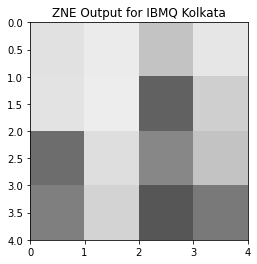

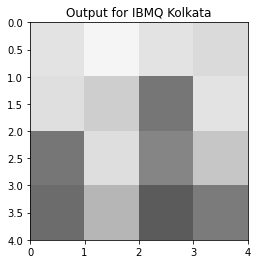

In [73]:
plot_image4x4_denormalized(np_zne_output, np_test_image, np_test_image_normalized, 'ZNE Output for IBMQ Kolkata')
plot_image4x4_denormalized(np_kolkata_output, np_test_image, np_test_image_normalized, 'Output for IBMQ Kolkata')

In [74]:
print("True Image:")
print(np_test_image)
print("IBMQ Kolkata:")
print(un_normalize(np_test_image, np_test_image_normalized, np_kolkata_output, 4))
print("IBMQ Kolkata with ZNE:")
print(un_normalize(np_test_image, np_test_image_normalized, np_zne_output, 4))

rmse_simulator = rmse_image_error(np_test_image, un_normalize(np_test_image, np_test_image_normalized, np_simulator_output, 4), 4)
rmse_kolkata = rmse_image_error(np_test_image, un_normalize(np_test_image, np_test_image_normalized, np_kolkata_output, 4), 4) 
rmse_zne = rmse_image_error(np_test_image, un_normalize(np_test_image, np_test_image_normalized, np_zne_output, 4), 4) 

print("Simulator error: ", (rmse_simulator * 100), "% per pixel")
print("IBMQ Kolkata error: ", (rmse_kolkata * 100), "% per pixel")
print("IMBQ Kolkata (with ZNE) error: ", (rmse_zne * 100), "% per pixel")

True Image:
[[0.8125     0.84765625 0.86328125 0.8515625 ]
 [0.88671875 0.89453125 0.22265625 0.8984375 ]
 [0.2890625  0.890625   0.49609375 0.8984375 ]
 [0.43359375 0.89453125 0.38671875 0.4375    ]]
IBMQ Kolkata:
[[0.89089213 0.95823818 0.89239068 0.85413834]
 [0.87117633 0.80650522 0.4646785  0.89269009]
 [0.46410304 0.86871884 0.52311464 0.77438748]
 [0.42377129 0.71406226 0.35740518 0.48051148]]
IBMQ Kolkata with ZNE:
[[0.88187956 0.9190985  0.7680476  0.89873255]
 [0.89443124 0.92864845 0.3825706  0.8095283 ]
 [0.42719601 0.86903848 0.52864304 0.76882582]
 [0.49904958 0.8317813  0.33849514 0.47610701]]
Simulator error:  0.4719698542319386 % per pixel
IBMQ Kolkata error:  1.935837042552313 % per pixel
IMBQ Kolkata (with ZNE) error:  2.028665852415622 % per pixel


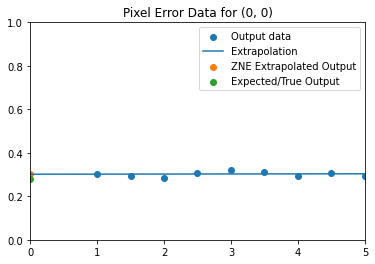

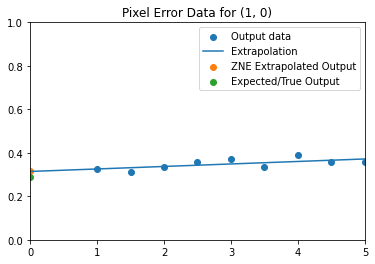

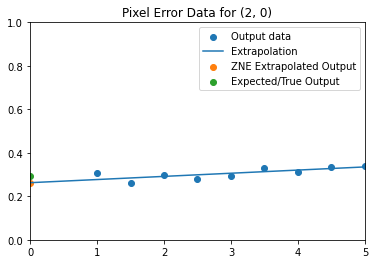

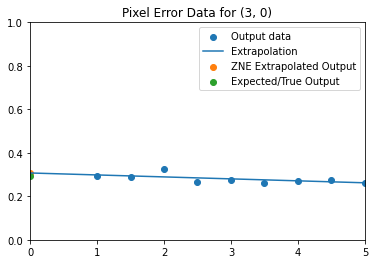

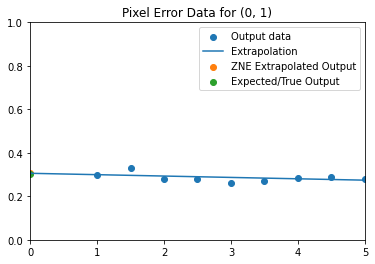

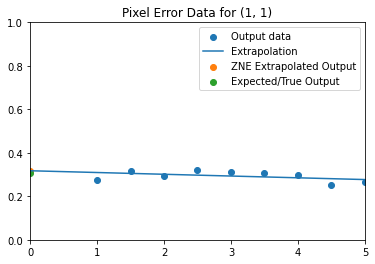

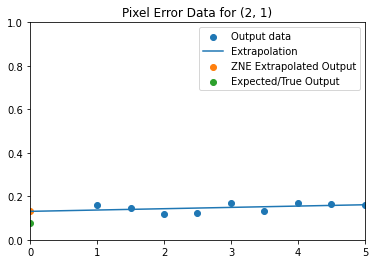

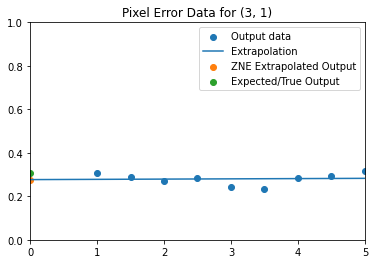

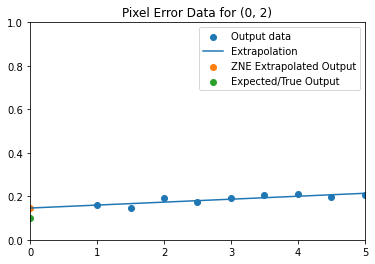

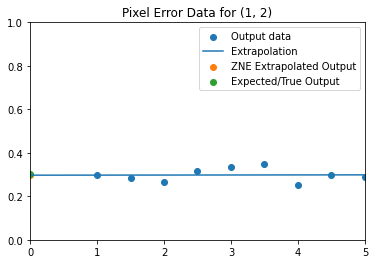

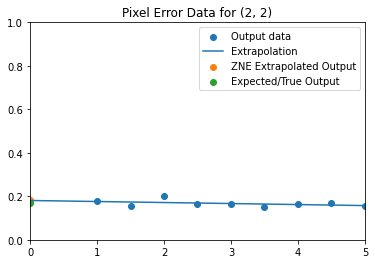

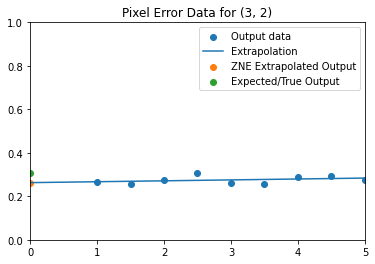

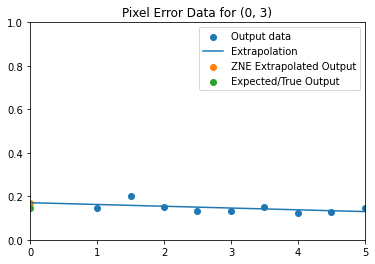

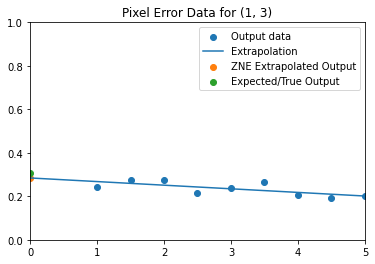

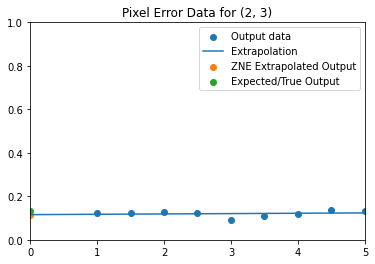

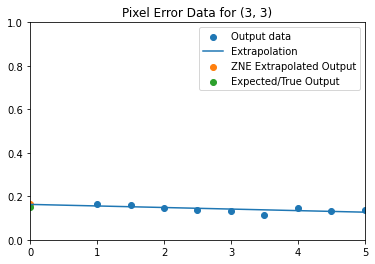

In [85]:
for y in range(4):
    for x in range(4):
        plot_pixel_error_linear(scale_factors, expectation_values, np_test_image_normalized, x, y, 4)

In [14]:
def un_normalize(true_image, true_image_normalized, image, n):
    normalization_factor = 0.0
    for x in range(n):
        for y in range(n):
            normalization_factor += (true_image_normalized[y][x] / true_image[y][x])
    
    #The average normalization factor, to account for floating point errors.
    normalization_factor /= (n**2)
    
    image = image / normalization_factor
    return image

def rmse_image_error(true_image, error_image, n):
    rms_error = 0.0
    for y in range(n):
        for x in range(n):
            rms_error += ((true_image[y][x] - error_image[y][x]) ** 2)
            
    rms_error = np.sqrt(rms_error)
    return (rms_error / (n**2))

In [8]:
# It seems that increasing error doesn't seem to affect the output too much.
# Increasing shots from 4000 to 16000 improved error.
# Let's try the maximum number of shots possible; 100000:
# Let's Run it on IBMQ_Kolkata!
scale_factors = [1., 1.5, 2., 2.5, 3., 3.5, 4., 4.5, 5.]
folded_circuits = [
        mitiq.zne.scaling.folding.fold_all(
        qc_image, scale) for scale in scale_factors
]

shots = 100000

# Running on actual Quantum Hardware:
IBMQ.load_account()
provider = IBMQ.get_provider(hub="ibm-q-iitmadras", group="mphasis-iitm", project="default")
backend_kolkata = provider.get_backend("ibmq_kolkata")
print("Chosen Backend: ", backend_kolkata)

job = qiskit.execute(
   experiments=folded_circuits,
   backend=backend_kolkata,
   optimization_level=0,  # We're adding our own error, so we don't want qiskit to optimize anything!
   shots=shots
)

ibmqfactory.load_account:WARNING:2022-10-03 11:59:32,698: Credentials are already in use. The existing account in the session will be replaced.


Chosen Backend:  ibmq_kolkata


In [9]:
# We're running on ibmq_kolkata, job_id: 633aceac1ff56939568b7e0a
IBMQ.load_account()
provider = IBMQ.get_provider(hub="ibm-q-iitmadras", group="mphasis-iitm", project="default")
backend_kolkata = provider.get_backend("ibmq_kolkata")
kolkata_job = backend_kolkata.retrieve_job('633aceac1ff56939568b7e0a')

print(kolkata_job)

ibmqfactory.load_account:WARNING:2022-10-03 12:03:10,308: Credentials are already in use. The existing account in the session will be replaced.


In [10]:
get_bin = lambda x, n: format(x, 'b').zfill(n)

def linear_function(x, a, b):
    return a + (b * x)

zne_output = []

all_counts = [kolkata_job.result().get_counts(i) for i in range(len(folded_circuits))]
expectation_values = []
for i in range(16):
    expectation_values.append([np.sqrt((counts.get(get_bin(i, 4)) / shots)) for counts in all_counts])
    
for i in range(16):
    param, param_cov = curve_fit(linear_function, scale_factors, expectation_values[i])
    zne_output.append(linear_function(0, param[0], param[1]))
    


np_zne_output = np.array(zne_output).reshape((4,4))

kolkata_output = []
for i in range(16):
    kolkata_output.append(expectation_values[i][0])
np_kolkata_output = np.array(kolkata_output).reshape((4,4))

print(np_zne_output)
print(np_kolkata_output)


[[0.2942461  0.31002321 0.28560062 0.31897347]
 [0.30547584 0.29333862 0.11017602 0.30732268]
 [0.14656902 0.31588908 0.16135449 0.29218222]
 [0.14587568 0.25317175 0.11572343 0.14653505]]
[[0.29018959 0.34225721 0.30935417 0.32753626]
 [0.29804362 0.2926773  0.13266499 0.33194879]
 [0.14855975 0.30479501 0.1419507  0.26359059]
 [0.10917875 0.21702534 0.09633276 0.14314328]]


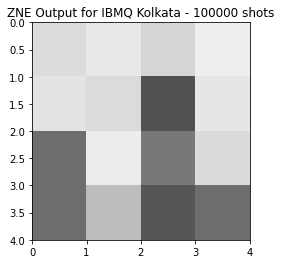

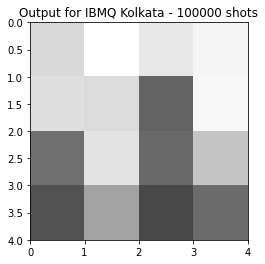

In [11]:
plot_image4x4_denormalized(np_zne_output, np_test_image, np_test_image_normalized, 'ZNE Output for IBMQ Kolkata - 100000 shots')
plot_image4x4_denormalized(np_kolkata_output, np_test_image, np_test_image_normalized, 'Output for IBMQ Kolkata - 100000 shots')

In [18]:
print("True Image:")
print(np_test_image)
print("IBMQ Kolkata:")
print(un_normalize(np_test_image, np_test_image_normalized, np_kolkata_output, 4))
print("IBMQ Kolkata with ZNE:")
print(un_normalize(np_test_image, np_test_image_normalized, np_zne_output, 4))

rmse_simulator = rmse_image_error(np_test_image, un_normalize(np_test_image, np_test_image_normalized, np_simulator_output, 4), 4)
rmse_kolkata = rmse_image_error(np_test_image, un_normalize(np_test_image, np_test_image_normalized, np_kolkata_output, 4), 4) 
rmse_zne = rmse_image_error(np_test_image, un_normalize(np_test_image, np_test_image_normalized, np_zne_output, 4), 4) 

print("Simulator error (100000 shots): ", (rmse_simulator * 100), "% per pixel")
print("IBMQ Kolkata error (100000 shots): ", (rmse_kolkata * 100), "% per pixel")
print("IMBQ Kolkata (with ZNE) error (100000 shots): ", (rmse_zne * 100), "% per pixel")

True Image:
[[0.8125     0.84765625 0.86328125 0.8515625 ]
 [0.88671875 0.89453125 0.22265625 0.8984375 ]
 [0.2890625  0.890625   0.49609375 0.8984375 ]
 [0.43359375 0.89453125 0.38671875 0.4375    ]]
IBMQ Kolkata:
[[0.84860135 1.00086268 0.90464431 0.95781419]
 [0.87156888 0.85587614 0.3879522  0.97071776]
 [0.43443324 0.89131198 0.41510638 0.7708179 ]
 [0.3192714  0.63464716 0.28170585 0.41859387]]
IBMQ Kolkata with ZNE:
[[0.86046379 0.9066008  0.83518182 0.93277405]
 [0.89330291 0.85781004 0.32218771 0.89870363]
 [0.42861175 0.92375435 0.47184888 0.85442838]
 [0.42658421 0.74035009 0.33840999 0.42851241]]
Simulator error (100000 shots):  0.4719698542319386 % per pixel
IBMQ Kolkata error (100000 shots):  2.850576277701329 % per pixel
IMBQ Kolkata (with ZNE) error (100000 shots):  1.6977685579889708 % per pixel


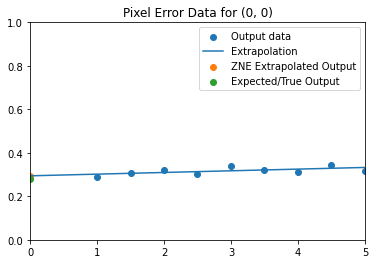

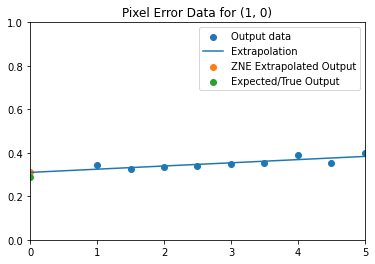

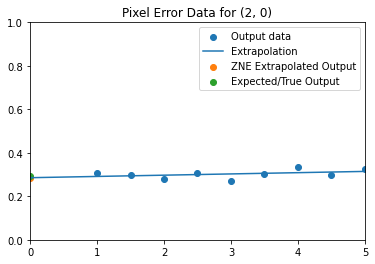

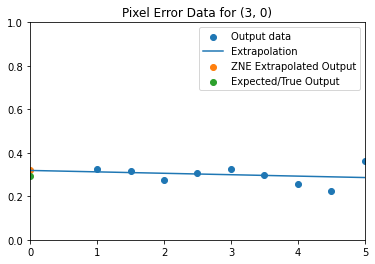

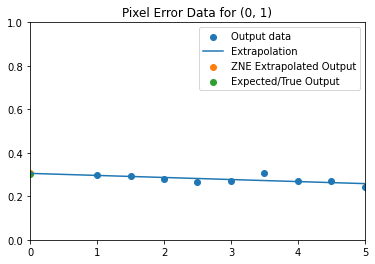

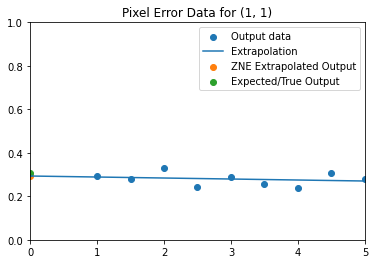

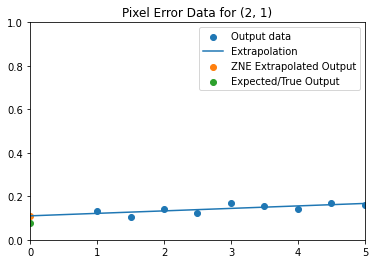

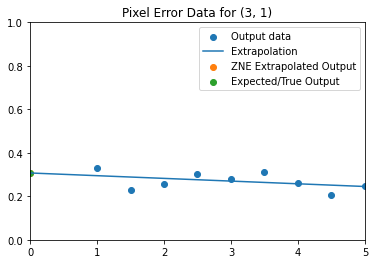

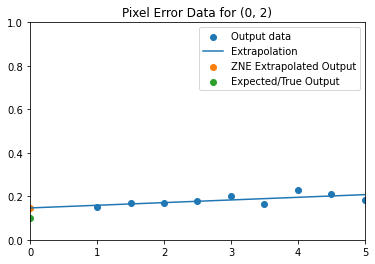

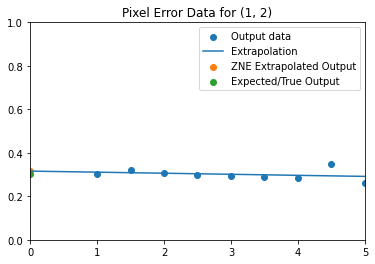

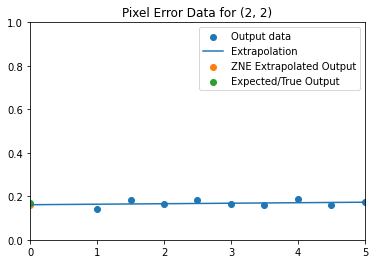

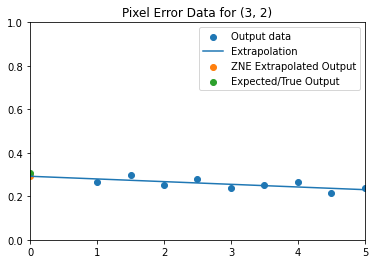

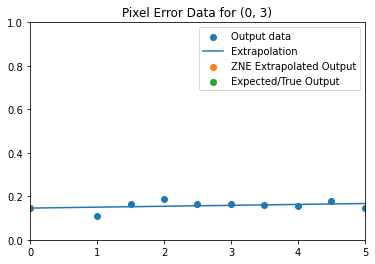

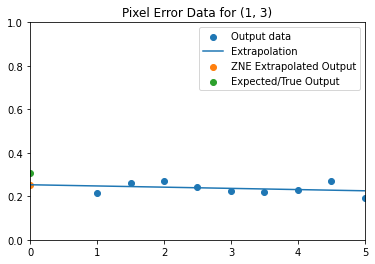

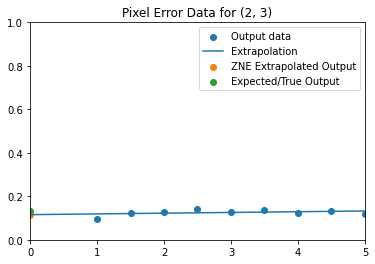

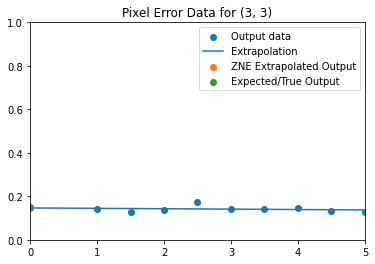

In [20]:
def linear_function(x, a, b):
    return a + (b * x)

def plot_pixel_error_linear(scale_factors, expectation_values, test_image_normalized, x, y, n):
    plt.xlim([0, 5])
    plt.ylim([0,1])

    scale_factors_fitted = np.linspace(0, 5, 100)

    plt.scatter(scale_factors, expectation_values[x + (y * n)], label="Output data")
    param, param_cov = curve_fit(linear_function, scale_factors, expectation_values[x + (y * n)])
    
    scale_factors_fitted_output = []
    for x_output in scale_factors_fitted:
        scale_factors_fitted_output.append(linear_function(x_output, param[0], param[1]))
        
    np_scale_factors_fitted_output = np.array(scale_factors_fitted_output)
    plt.plot(scale_factors_fitted, np_scale_factors_fitted_output, label="Extrapolation" )

    plt.scatter(0, linear_function(0, param[0], param[1]), label="ZNE Extrapolated Output")
    plt.scatter(0, test_image_normalized[y][x], label="Expected/True Output")

    plt.title("Pixel Error Data for (" + str(x) + ", " + str(y) + ")")
    plt.legend()
    plt.show()


for y in range(4):
    for x in range(4):
        plot_pixel_error_linear(scale_factors, expectation_values, np_test_image_normalized, x, y, 4)